In [9]:
#基于Fingerprint开展相似度评估、


In [2]:
# 加载包
import numpy as np
import pandas as pd
from rdkit import DataStructs
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
from fragments2mol import *

In [3]:
# 指纹计算函数，有四种指纹
# MACCS Keys,Topological Fingerprint,
# Morgan fingerprint,Avalon fingerprint
class cal_fingerprint:
    '''
    ** 选择哪个指纹，依据构效关系的输入

    四种指纹计算
    MACCS Keys,
    rdkit Topological Fingerprint,**
    Morgan fingerprint,**
    Avalon fingerprint

    :param smi_list: 分子列表smiles或者mol
    '''
    def __init__(self, smi_list):
        # 获得分子的smiles以及mol
        if type(smi_list[0]) is str:
            self.mols = read_mol(smi_list)
            self.smi_list = smi_list
        else:
            self.mols = smi_list
            self.smi_list = read_mol(smi_list,smiles2mol=0)

    def MACCSkey(self):
        '''
        166种分子的部分分子结构，当含有该分子结构时显示1没有的时候显示0，
        还包括了rdkit的相关内容，对一个分子来说总共是167bit的分子指纹
        '''
        fingerprints = []
        smi_calc = []
        for smi, mol in zip(self.smi_list, self.mols):

            try:
                fingerprint = AllChem.GetMACCSKeysFingerprint(mol)
                fingerprints.append(fingerprint)
                smi_calc.append(smi)
            except:
                print("Error", smi)
                continue
        self.smi_calc = smi_calc
        self.fingerprints = fingerprints
        self.fp_MACCSkeys = pd.DataFrame(data=np.array(fingerprints), index=smi_calc)

    def RDKitTopological(self,fpSize=2048):
        '''
        Topological Fingerprint的算法类似于Daylight Fingerprint，
        另外也被称为RDKit Fingerprint
        fpSize：生成指纹的长度，默认2048
        '''
        fingerprints = []
        smi_calc = []
        for smi, mol in zip(self.smi_list, self.mols):

            try:
                fingerprint = Chem.RDKFingerprint(mol,fpSize=fpSize)
                fingerprints.append(fingerprint)
                smi_calc.append(smi)
            except:
                print("Error", smi)
                continue
        self.smi_calc = smi_calc
        self.fingerprints = fingerprints
        self.fp_TopoFingerprint = pd.DataFrame(data=np.array(fingerprints), index=smi_calc)

    def Morgan(self,radius=2, fpSize=2048):
        '''
        摩根分子指纹，也成为圆形指纹，是采用摩根算法而产生。
        使用时，需要提供原子半径。
        radius:考虑半径
        fpSize：生成指纹的长度，默认2048
        '''
        fingerprints = []
        smi_calc = []
        for smi, mol in zip(self.smi_list, self.mols):

            try:
                fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol,radius=radius,nBits=fpSize)
                fingerprints.append(fingerprint)
                smi_calc.append(smi)
            except:
                print("Error", smi)
                continue
        self.smi_calc = smi_calc
        self.fingerprints = fingerprints
        self.fp_Morgan = pd.DataFrame(data=np.array(fingerprints), index=smi_calc)

    def Avalon(self, fpSize=2048):
        '''
        https://pubs.acs.org/doi/pdf/10.1021/ci050413p
        fpSize：生成指纹的长度，默认2048
        '''
        fingerprints = []
        smi_calc = []
        for smi, mol in zip(self.smi_list, self.mols):

            try:
                fingerprint = pyAvalonTools.GetAvalonFP(mol,nBits=fpSize)
                fingerprints.append(fingerprint)
                smi_calc.append(smi)
            except:
                print("Error", smi)
                continue
        self.smi_calc = smi_calc
        self.fingerprints = fingerprints
        self.fp_Avalon = pd.DataFrame(data=np.array(fingerprints), index=smi_calc)

In [4]:
# 相似性计算
# 相似度比较：DataStructs.FingerprintSimilarity(fp1, fp2, metric)
# fp1, fp2：待比较的分子
# metric：距离度量方法，默认为DataStructs.TanimotoSimilarity

def fp_smilarity_type(fp_type=0,smilarity_type=0):
    '''
    选择 指纹和相似性 的类型
    :param fp_type: 默认0 Morgan
    :param smilarity_type: 默认0  TanimotoSimilarity
    :return: 对应的计算器
    '''

    metic_dict = {0: 'DataStructs.TanimotoSimilarity',
                   1: 'DataStructs.DiceSimilarity',
                   2: 'DataStructs.CosineSimilarity',
                   3: 'DataStructs.SokalSimilarity',
                   4: 'DataStructs.RusselSimilarity',
                   5: 'DataStructs.KulczynskiSimilarity',
                   6: 'DataStructs.McConnaugheySimilarity',
                   7: 'DataStructs.RogotGoldbergSimilarity',
                   8: 'DataStructs.AllBitSimilarity',
                   9: 'DataStructs.AsymmetricSimilarity',
                   10: 'DataStructs.BraunBlanquetSimilarity'}
    fp_types = {0:'SimilarityMaps.GetMorganFingerprint',
                1:'SimilarityMaps.GetRDKFingerprint'}

    selected_fp, selected_smilarity = fp_types[fp_type],metic_dict[smilarity_type]
    return selected_fp, selected_smilarity

class MolSimilarity:
    def __init__(self,fp1,fp2,select_index=list(range(11))):
        '''
        :param fp1: 分子1的fingerprints (如 cal_fingerprint.Avalon.fingerprints)
        :param fp2: 分子2的fingerprints
        metic_dict: 所有相似性衡量指标函数，可以先print再选择
        :param select_index: 选择的相似性指标 如[0,5,9], 默认所有的
        :return: 相似度指纹列表
        '''

        self.fp1 = fp1
        self.fp2 = fp2

        self.select_Similarity = [DataStructs.FingerprintSimilarity(self.fp1,self.fp2,
                                                                    metric=eval(fp_smilarity_type(0,x)[1])) for x in list(range(11))]

def Similarity_heatmap(smi_list,select_fp_type ='Morgan',select_Similarity_index=0,radius=2, fpSize=2048):
    '''
    ** 通过人工找寻不同程度相似性的分子，计算相似性并整理成表，判断何种相似性指标最合适
    :param smi_list: smiles列表
    :param select_index: 选定相似性指标类型，默认0: 'DataStructs.TanimotoSimilarity'
    :return: N*N的相似性矩阵
    '''

    my_fp_cal = cal_fingerprint(smi_list)
    ALL_fp_type = {'MACCSkey': my_fp_cal.MACCSkey(),
                   'RDKitTopological': my_fp_cal.RDKitTopological(fpSize=fpSize),
                   'Morgan': my_fp_cal.Morgan(radius=radius, fpSize=fpSize),
                   'Avalon': my_fp_cal.Avalon(fpSize=fpSize)}

    _ = ALL_fp_type[select_fp_type] # 激活对应fp计算器
    fingerprints = my_fp_cal.fingerprints # 所有分子对应的fp
    smi_calc = my_fp_cal.smi_calc # 有效被计算到的smiles
    N_smi = len(smi_calc) # 分子数

    result = {} # 保存结果
    for i in range(N_smi):
        result[smi_calc[i]] = []
        for j in range(N_smi):
            fp1,fp2 = fingerprints[i], fingerprints[j]
            Similarity = MolSimilarity(fp1,fp2,select_index=[select_Similarity_index])
            result[smi_calc[i]].append(Similarity.select_Similarity[0])

    return pd.DataFrame(data=result, index=smi_calc, columns=smi_calc)

def Similarity_molMap(refmol,mol,fp_type=0,smilarity_type=0):
    selected_fp_type,selected_smilarity_type = fp_smilarity_type(fp_type,smilarity_type)
    fig, _ = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, eval(selected_fp_type), eval(selected_smilarity_type))
    return fig

In [5]:
# 分子随机抽样
def random_sample(smi_path,n,random_seed=2023):
    '''
    :param smi_path: 带有smiles的csv文件
    :param n: 需要抽取的数量
    :param random_seed: 随机种子
    :return: 抽取结果表
    '''
    df = pd.read_csv(smi_path)
    try:
        df = df['addH_SMILES']
    except:
        df = df['SMILES']

    if n != 'all':
        subset = df.sample(n=n,random_state=random_seed)
    else:
        subset = df

    return subset

In [6]:
## 测试 指纹计算
smi_path = "F:\WORK\和外合作\天宇媛媛毕设\初始数据\清洗后分子总样本smiles.csv"
sample_data = random_sample(smi_path,n=10)
smi_list = sample_data.values
fp_calc = cal_fingerprint(smi_list=smi_list)
# fp_calc.MACCSkey()
# fp_calc.fp_MACCSkeys
# fp_calc.RDKitTopological(fpSize=1024)
# fp_calc.fp_TopoFingerprint

fp_calc.Morgan(radius=2,fpSize=1024)
fp_calc.fingerprints[0].GetNumBits()
fp_calc.fp_Morgan

# fp_calc.Avalon(fpSize=1024)
# fp_calc.fp_Avalon


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
O(C(COCC=C)COCC=C)C1CCS(=O)(=O)C1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
O(C)c1cc(CCNC(=O)C(=O)NCCc2ccc(OC)c(OC)c2)ccc1OC,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1(=O)C=C(OC)C=C(C1=O)C(C)(C)C,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O(C(C)=O)C1C(OC(C)=O)C(OC(C)=O)C(COC(C)=O)OC1N2N=C(CBr)C=C2C(N)=O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
C(=O)(O)C1C2C=CC3(CN(CCc4ccc(OCc5ccccc5)c(OC)c4)CC13)O2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
C(CCCC(=O)OCC)c1ccc(cc1)C(C)=O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
O(C(=O)Nc1cccc(OC)c1)c2ccc(CC=C)cc2OC,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O=C1SC=Cc2ccccc12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C(=NNC(N)=S)c1cccc(n1)C=NNC(N)=S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
N(C(=O)COC)c1ccc(cc1)c2ccc(N)cc2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
## 测试 相似性计算
mol = 'COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21'
refmol = 'CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1'
fp_calc = cal_fingerprint(smi_list=[mol,refmol])
fp_calc.Morgan(radius=2,fpSize=1024)
fp1,fp2 = fp_calc.fingerprints[0], fp_calc.fingerprints[1]
my_MolSimilarity = MolSimilarity(fp1,fp2)
my_MolSimilarity.select_Similarity

[0.3902439024390244,
 0.5614035087719298,
 0.5635759629410775,
 0.24242424242424243,
 0.03125,
 0.56575682382134,
 0.1315136476426799,
 0.7677751773435657,
 0.951171875,
 0.6153846153846154,
 0.5161290322580645]

In [14]:
## 测试 相似性矩阵计算
smi_path = "F:\WORK\和外合作\天宇媛媛毕设\初始数据\清洗后分子总样本smiles.csv"
sample_data = random_sample(smi_path,n=10)
smi_list = sample_data.values
Similarity_heatmap(smi_list,select_fp_type ='Morgan',select_Similarity_index=0,radius=2, fpSize=2048)


NameError: name 'pd' is not defined

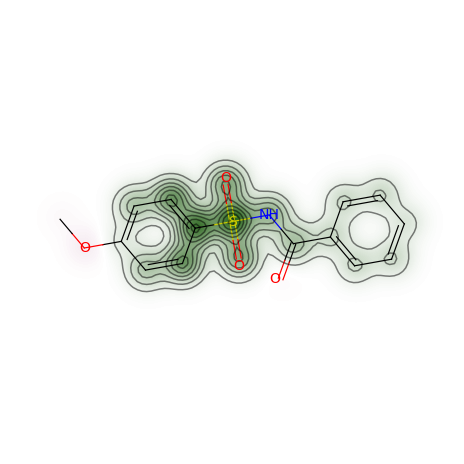

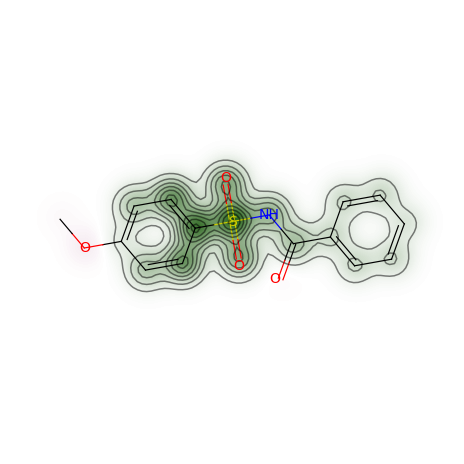

In [12]:
## 测试 相似性地图
mol = Chem.MolFromSmiles('S(=O)(=O)(NC(=O)c1ccccc1)c2ccc(OC)cc2')
refmol = Chem.MolFromSmiles('c1cc(C)ccc1S(=O)(=O)N(CC(=O)O)c2ccccc2')
Similarity_molMap(refmol, mol, fp_type=1,smilarity_type=0)

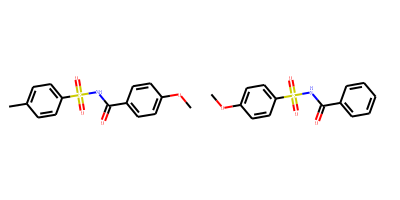

In [9]:
draw_multi_mol([refmol, mol], "mols",2)

0


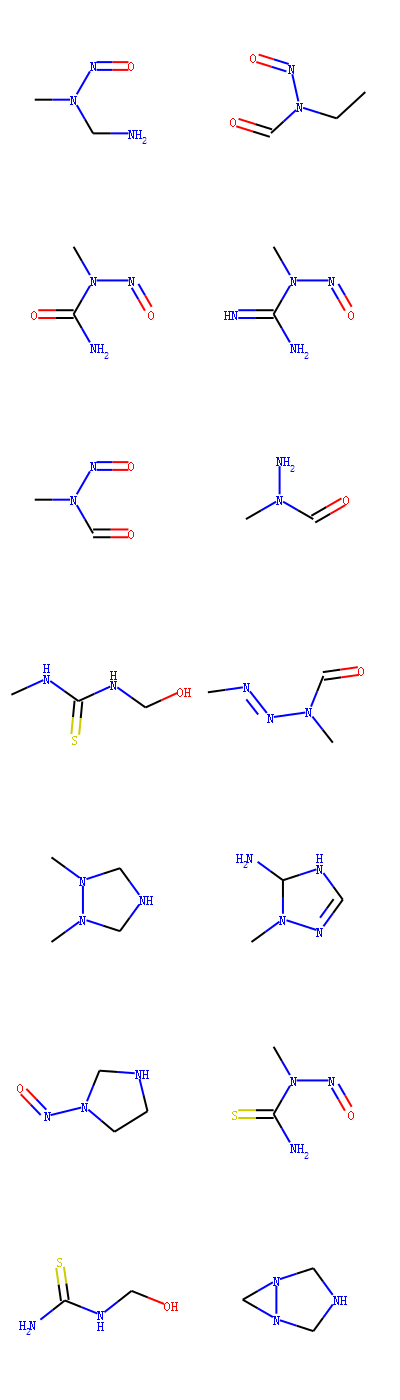